# Brazil Real Estate Pricing Research


In [114]:
# | hide
import pandas as pd
import numpy as np
import datetime
import typing as t
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
import math

In [2]:
# | hide
np.random.seed(42)

I want to predict future prices for houses and apartments. To do it, my plan is to build a model to predict price given latitude, longitude, and a set of features (like number of rooms, square footage, etc) and a date in the range of my data (2013 to 2016) and another model to build this forecast to current prices (2023) and future prices (2030, for example).

In this research I will focus on the first model. The next one will be developed in the future.

To do price calculation I developed a "new" approach due to lack of spatial features. Here I'm going to call it "KNN Spatial Boost". I tested 5 models:

- Random Forest
- KNN
- Neural Network
- Spatial Boosted Random Forest
- Spatial Boosted Neural Network

The "KNN Spatial Boost" is a boosting algorithm to improve other models performance in spatial data. It's almost a feature engineering technique because it add k-nearest neighbors (based on specific features) as features but in addition, randomize those neighbors a little bit in the training routine to reduce the model dependency on the dataset and improve generalization.

To read more about the algorithm, visit the [code repository](https://github.com/cl3t0/knn-spatial-boost).


## Data Exploration & Data Cleaning

Heres my [initial dataset](https://www.kaggle.com/datasets/devvret/brazil-real-estate-listings/). We need to check for outliers, missing fields, and see some distributions to identify data skewness.


In [38]:
raw_df = pd.read_csv("properati-BR-2016-11-01-properties-sell.csv", sep=",")
raw_df.head(3)

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,2013-04-25,sell,apartment,Mondubim,|Brasil|Ceará|Fortaleza|Mondubim|,NaN,NaN,NaN,NaN,155900.0,...,NaN,NaN,NaN,NaN,2.0,NaN,http://mondubim.properati.com.br/px9_vende-se_...,"Otimo Imovel com o melhor valor da regiao, con...",Apartamento Em Fortaleza,https://thumbs-cf.properati.com/8/EY670SQWML7c...
1,2013-04-25,sell,house,Manhuaçu,|Brasil|Minas Gerais|Manhuaçu|,NaN,NaN,NaN,NaN,950000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,http://manhuacu.properati.com.br/pxv_vende-se_...,"Otimo Imovel com o melhor valor da regiao, con...",Casa Em Manhuacu,https://thumbs-cf.properati.com/1/1VGQees9LIbx...
2,2013-04-25,sell,house,Ibatiba,|Brasil|Espírito Santo|Ibatiba|,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://ibatiba.properati.com.br/pxw_vende-se_o...,"Otimo Imovel com o melhor valor da regiao, con...",Sítio Em Ibatiba,NaN


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872672 entries, 0 to 872671
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   created_on                  872672 non-null  object 
 1   operation                   872672 non-null  object 
 2   property_type               872672 non-null  object 
 3   place_name                  872672 non-null  object 
 4   place_with_parent_names     872672 non-null  object 
 5   geonames_id                 140 non-null     float64
 6   lat-lon                     387227 non-null  object 
 7   lat                         387227 non-null  float64
 8   lon                         387227 non-null  float64
 9   price                       819401 non-null  float64
 10  currency                    819382 non-null  object 
 11  price_aprox_local_currency  819401 non-null  float64
 12  price_aprox_usd             819401 non-null  float64
 13  surface_total_

Our feature selection process will be based on non-null so we are going to select

- created_on
- property_type
- lat
- lon
- price
- surface_covered_in_m2
- rooms
- description

I would love to use `floor` and `surface_total_in_m2` as features but they are filled for less then 10% for the dataset. The `description` column wasn't dropped to enable single row analysis to identify anomalies or outliers. In the future it can be used with NLP to improve price prediction accuracy.

But before selecting them we need to make some other analysis. For example, which categories do we have in `property_type` and in `currency`?


/tmp/ipykernel_52362/2208899610.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


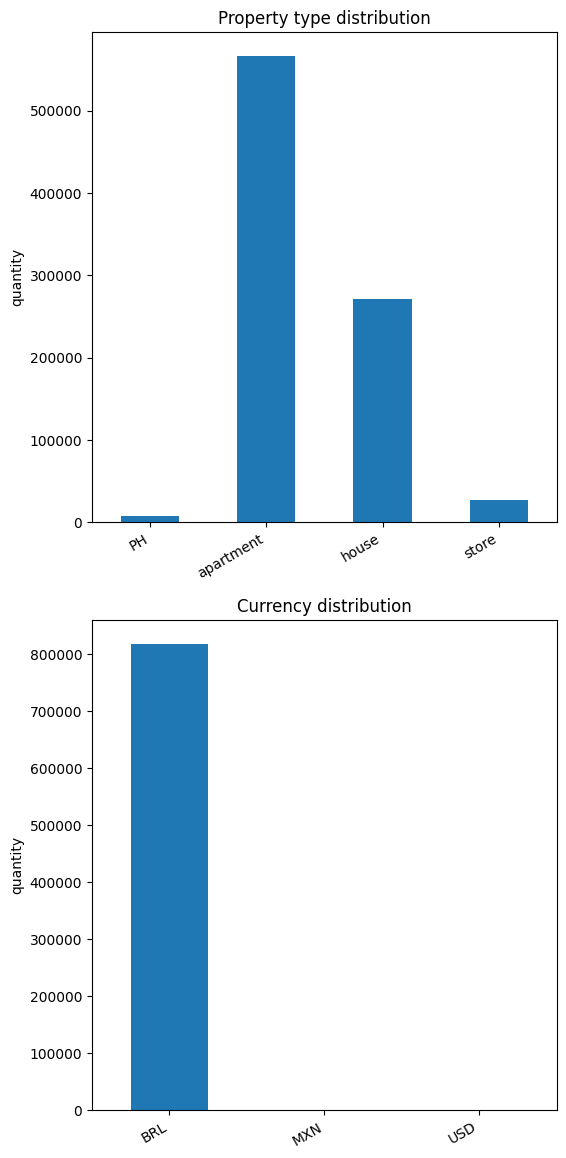

In [129]:
fig, ax = plt.subplots(2, figsize=(6, 14))

ax[0].title.set_text("Property type distribution")
ax[0].set_ylabel("quantity")
raw_df[raw_df.property_type.notnull()].property_type.value_counts().sort_index().plot(
    kind="bar", ax=ax[0], xlabel=""
)
plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment="right")

ax[1].title.set_text("Currency distribution")
ax[1].set_ylabel("quantity")
raw_df[raw_df.currency.notnull()].currency.value_counts().sort_index().plot(
    kind="bar", ax=ax[1], xlabel=""
)
plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment="right")
fig.show()

Unbalanced values can cause problem to model performance. Because of it we are going to drop PH, stores, and non-BRL rows. For continous features we need to do a similar analysis.


/tmp/ipykernel_52362/4022627496.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


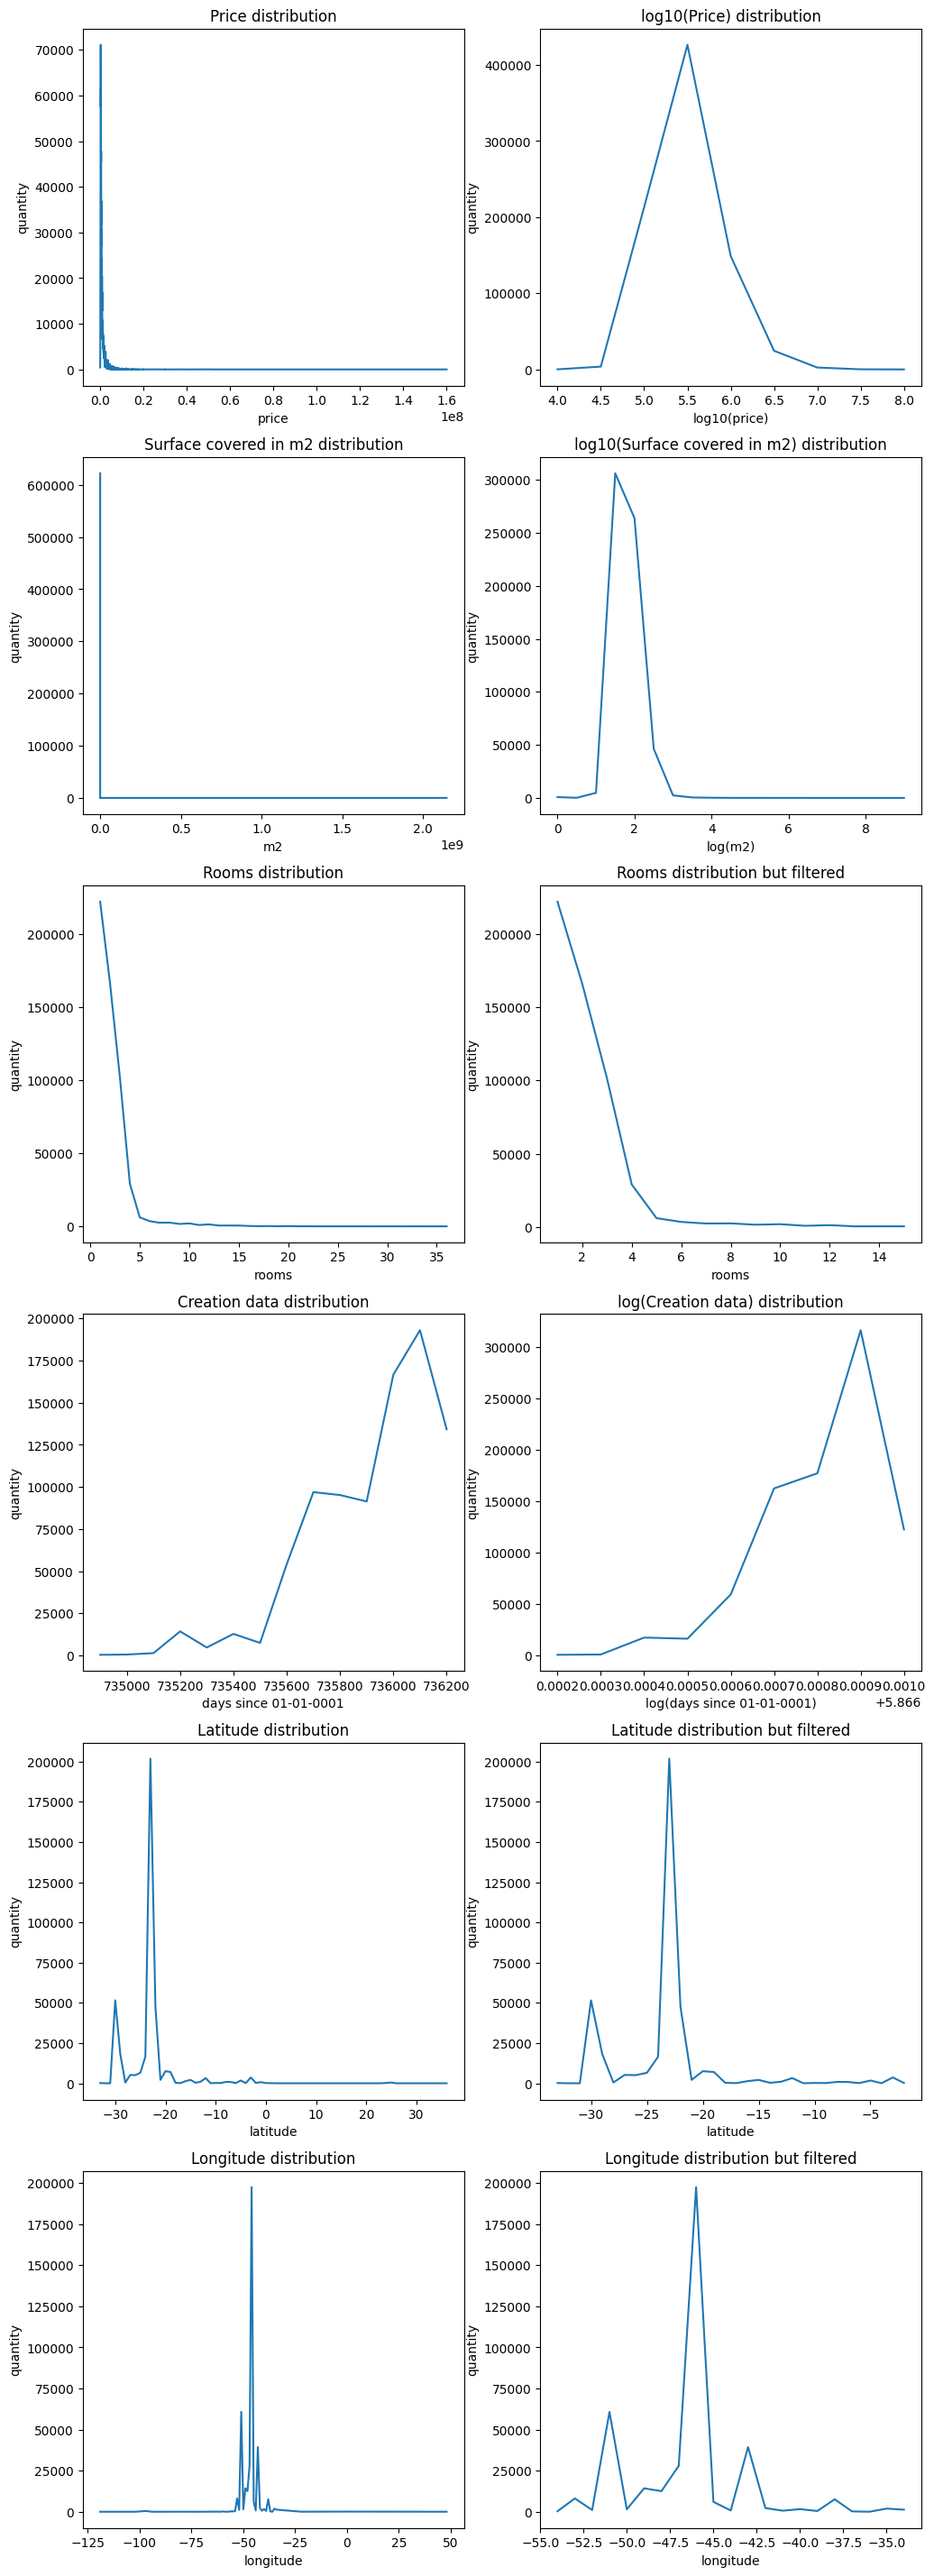

In [132]:
def group_values(series: pd.Series, group_size: float) -> pd.Series:
    return ((series / group_size).map(int) * group_size).value_counts().sort_index()


fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 36))

ax[0, 0].title.set_text("Price distribution")
ax[0, 0].set_xlabel("price")
ax[0, 0].set_ylabel("quantity")
ax[0, 0].plot(group_values(raw_df[raw_df.price > 0].price, 50000))

ax[0, 1].title.set_text("log10(Price) distribution")
ax[0, 1].set_xlabel("log10(price)")
ax[0, 1].set_ylabel("quantity")
ax[0, 1].plot(group_values(np.log10(raw_df[raw_df.price > 0].price), 0.5))

ax[1, 0].title.set_text("Surface covered in m2 distribution")
ax[1, 0].set_xlabel("m2")
ax[1, 0].set_ylabel("quantity")
ax[1, 0].plot(
    group_values(raw_df[raw_df.surface_covered_in_m2 > 0].surface_covered_in_m2, 1000)
)

ax[1, 1].title.set_text("log10(Surface covered in m2) distribution")
ax[1, 1].set_xlabel("log(m2)")
ax[1, 1].set_ylabel("quantity")
ax[1, 1].plot(
    group_values(
        np.log10(raw_df[raw_df.surface_covered_in_m2 > 0].surface_covered_in_m2),
        0.5,
    )
)

ax[2, 0].title.set_text("Rooms distribution")
ax[2, 0].set_xlabel("rooms")
ax[2, 0].set_ylabel("quantity")
ax[2, 0].plot(group_values(raw_df[raw_df.rooms.notnull()].rooms, 1))

ax[2, 1].title.set_text("Rooms distribution but filtered")
ax[2, 1].set_xlabel("rooms")
ax[2, 1].set_ylabel("quantity")
ax[2, 1].plot(group_values(raw_df[raw_df.rooms < 16].rooms, 1))

ax[3, 0].title.set_text("Creation data distribution")
ax[3, 0].set_xlabel("days since 01-01-0001")
ax[3, 0].set_ylabel("quantity")
ax[3, 0].plot(
    group_values(
        raw_df[raw_df.created_on.notnull()]
        .created_on.map(datetime.datetime.fromisoformat)
        .map(datetime.datetime.toordinal),
        100,
    )
)

ax[3, 1].title.set_text("log(Creation data) distribution")
ax[3, 1].set_xlabel("log(days since 01-01-0001)")
ax[3, 1].set_ylabel("quantity")
ax[3, 1].plot(
    group_values(
        np.log10(
            raw_df[raw_df.created_on.notnull()]
            .created_on.map(datetime.datetime.fromisoformat)
            .map(datetime.datetime.toordinal)
        ),
        0.0001,
    )
)

ax[4, 0].title.set_text("Latitude distribution")
ax[4, 0].set_xlabel("latitude")
ax[4, 0].set_ylabel("quantity")
ax[4, 0].plot(group_values(raw_df[raw_df.lat.notnull()].lat, 1))

ax[4, 1].title.set_text("Latitude distribution but filtered")
ax[4, 1].set_xlabel("latitude")
ax[4, 1].set_ylabel("quantity")
ax[4, 1].plot(group_values(raw_df[raw_df.lat < -2].lat, 1))

ax[5, 0].title.set_text("Longitude distribution")
ax[5, 0].set_xlabel("longitude")
ax[5, 0].set_ylabel("quantity")
ax[5, 0].plot(group_values(raw_df[raw_df.lon.notnull()].lon, 1))

ax[5, 1].title.set_text("Longitude distribution but filtered")
ax[5, 1].set_xlabel("longitude")
ax[5, 1].set_ylabel("quantity")
ax[5, 1].plot(group_values(raw_df[(raw_df.lon < -34) & (raw_df.lon > -55)].lon, 1))

fig.show()

Note that some of those feature is worth apply some non-linear normalization like logarithm. The price and the surface covered in m2 are obviously skewed so I'm going to apply log to them. Rooms, creation date, latitude, and longitude are not so much so I'm only going to apply some linear transformation and filtering to them.


In [54]:
df = raw_df[
    raw_df.created_on.notnull()
    & (raw_df.lat < -2)
    & (raw_df.lon < -34)
    & (raw_df.lon > -55)
    & (raw_df.price > 0)
    & (raw_df.rooms < 16)
    & (raw_df.surface_covered_in_m2 > 0)
    & (raw_df.surface_covered_in_m2 < 5000)
    & (raw_df.currency == "BRL")
    & ((raw_df.property_type == "apartment") | (raw_df.property_type == "house"))
][
    [
        "lat",
        "lon",
        "created_on",
        "property_type",
        "price",
        "surface_covered_in_m2",
        "rooms",
        "description",
    ]
]
df.created_on = pd.to_datetime(df.created_on)
df.head(3)

,lat,lon,created_on,property_type,price,surface_covered_in_m2,rooms,description
792,-3.474983,-38.928616,2013-06-26,house,5000000.0,1000.0,8.0,"Casa de praia em Taíba, a apenas 67 km de Fort..."
794,-23.547697,-46.657379,2013-09-04,apartment,2000000.0,180.0,3.0,EXCELENTE OPORTUNIDADE!!\n\nAPARTAMENTO TOTALM...
795,-23.545349,-46.659519,2013-09-04,apartment,960000.0,109.0,3.0,"IMOVEL SITO NA RUA ALAGOAS, BEM LOCALIZADO, EM..."


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156377 entries, 792 to 872667
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lat                    156377 non-null  float64       
 1   lon                    156377 non-null  float64       
 2   created_on             156377 non-null  datetime64[ns]
 3   property_type          156377 non-null  object        
 4   price                  156377 non-null  float64       
 5   surface_covered_in_m2  156377 non-null  float64       
 6   rooms                  156377 non-null  float64       
 7   description            156377 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 10.7+ MB


Here's a geographical view of the data. For future comparison we are going to "zoom in" Belo Horizonte (BH), which is a big city, filter to only apartments with 1 room and square footage between 60 and 80. The logarithm is to show colors in a more smooth way.


In [40]:
bh_lats = (-19.99491, -19.83163)
bh_longs = (-44.02857, -43.90612)

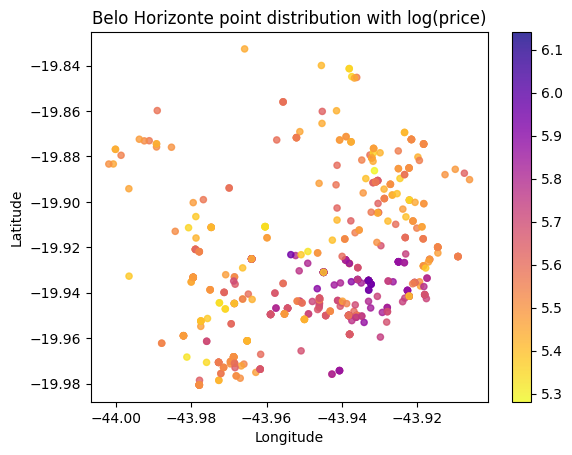

In [53]:
bh_df = df[
    (df.lat > bh_lats[0])
    & (df.lat < bh_lats[1])
    & (df.lon > bh_longs[0])
    & (df.lon < bh_longs[1])
    & (df.property_type == "apartment")
    & (df.surface_covered_in_m2 > 60)
    & (df.surface_covered_in_m2 < 80)
    & (df.rooms == 1)
]
plt.scatter(
    bh_df["lon"],
    bh_df["lat"],
    s=20,
    c=np.log10(bh_df["price"]),
    cmap="plasma_r",
    alpha=0.8,
)
plt.colorbar()
plt.title("Belo Horizonte point distribution with log(price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [59]:
def prepare_one_hots(x: pd.DataFrame) -> pd.DataFrame:
    x.loc[:, "is_house"] = 0
    x.loc[x.property_type == "house", "is_house"] = 1

    x.loc[:, "is_apartment"] = 0
    x.loc[x.property_type == "apartment", "is_apartment"] = 1

    x.drop(columns=["property_type"], inplace=True)
    return x


ordinal_created_on = df.created_on.map(datetime.datetime.toordinal)
min_created_on = ordinal_created_on.min()
max_created_on = ordinal_created_on.max()
min_lat = df.lat.min()
max_lat = df.lat.max()
min_lon = df.lon.min()
max_lon = df.lon.max()
min_rooms = df.rooms.min()
max_rooms = df.rooms.max()
min_lon = df.lon.min()
max_lon = df.lon.max()
log_price = np.log10(df.price)
min_log_price = log_price.min()
max_log_price = log_price.max()
log_m2 = np.log10(df.surface_covered_in_m2)
min_m2 = log_m2.min()
max_m2 = log_m2.max()


def normalize_xs(x: pd.DataFrame) -> pd.DataFrame:
    x.created_on = (x.created_on - min_created_on) / (max_created_on - min_created_on)
    x.lat = (x.lat - min_lat) / (max_lat - min_lat)
    x.lon = (x.lon - min_lon) / (max_lon - min_lon)
    x.rooms = (x.rooms - min_rooms) / (max_rooms - min_rooms)
    log_m2 = np.log10(x.surface_covered_in_m2)
    x.surface_covered_in_m2 = (log_m2 - min_m2) / (max_m2 - min_m2)
    return x


def normalize_y(x: pd.DataFrame) -> pd.DataFrame:
    log_price = np.log10(x.price)
    x.price = (log_price - min_log_price) / (max_log_price - min_log_price)
    return x


def denormalize_y(y: np.ndarray) -> pd.DataFrame:
    return (10 ** (min_log_price + y * (max_log_price - min_log_price))).round(2)


def prepare(x: pd.DataFrame) -> pd.DataFrame:
    new_x = x.copy()
    new_x.created_on = new_x.created_on.map(datetime.datetime.toordinal)
    new_x.drop(columns=["description"], inplace=True)
    return normalize_xs(normalize_y(prepare_one_hots(new_x)))


prepared_df = prepare(df)
prepared_df.head(3)

,lat,lon,created_on,price,surface_covered_in_m2,rooms,is_house,is_apartment
792,0.964178,0.793751,0.00000,0.690749,0.811764,0.500000,1,0
794,0.243744,0.407479,0.05719,0.578265,0.610249,0.142857,0,1
795,0.243829,0.407372,0.05719,0.488163,0.551303,0.142857,0,1


Before start training, we are going to split our dataset into training dataset and validation dataset.


In [56]:
def split_dataset(
    dataset: pd.DataFrame, test_ratio: float = 0.30
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]


train, valid = split_dataset(prepared_df)
X_train = train.loc[:, train.columns != "price"].to_numpy()
y_train = train.price.to_numpy()
X_valid = valid.loc[:, valid.columns != "price"].to_numpy()
y_valid = valid.price.to_numpy()
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(109432, 7)
(109432,)
(46945, 7)
(46945,)


## Sanity checks

Even with the validation dataset we want to make some sanity checks after the training. To do it so, we built this function which evaluates the model with specific features. It's a _curried_ function because there are some standarized checks to apply to all models.


In [85]:
def eval(
    lat: t.Union[float, np.ndarray],
    lon: t.Union[float, np.ndarray],
    created_on: t.Union[datetime.date, t.List[datetime.date]],
    property_type: t.Literal["apartment", "house"],
    surface_covered_in_m2: t.Union[float, np.ndarray],
    rooms: t.Union[int, np.ndarray],
) -> t.Callable[[t.Any], pd.DataFrame]:
    lat_vec = lat if isinstance(lat, np.ndarray) else np.array([lat])
    lon_vec = lon if isinstance(lon, np.ndarray) else np.array([lon])
    created_on_vec = (
        np.array([c.toordinal() for c in created_on])
        if isinstance(created_on, t.List)
        else np.array([created_on.toordinal()])
    )
    surface_covered_in_m2_vec = (
        surface_covered_in_m2
        if isinstance(surface_covered_in_m2, np.ndarray)
        else np.array([surface_covered_in_m2])
    )
    rooms_vec = rooms if isinstance(rooms, np.ndarray) else np.array([rooms])

    m = np.vstack(
        [
            v.ravel()
            for v in np.meshgrid(
                lat_vec,
                lon_vec,
                created_on_vec,
                surface_covered_in_m2_vec,
                rooms_vec,
                indexing="ij",
            )
        ]
    ).T

    x_df = pd.DataFrame(
        {
            "lat": m[:, 0],
            "lon": m[:, 1],
            "created_on": m[:, 2],
            "property_type": [property_type] * len(m),
            "surface_covered_in_m2": m[:, 3],
            "rooms": m[:, 4],
        }
    )
    x = normalize_xs(prepare_one_hots(x_df.copy())).to_numpy()

    def fn(model: t.Any) -> pd.DataFrame:
        y = model.predict(x)
        x_df["price"] = denormalize_y(y.reshape(len(m)))
        return x_df

    return fn

Here's all sanity checks:


In [86]:
lats = np.linspace(bh_lats[0], bh_lats[1], 100)
longs = np.linspace(bh_longs[0], bh_longs[1], 50)

santacruz = (-19.87755, -43.94184)
sion = (-19.95408, -43.93163)

start = datetime.date(2013, 7, 1)
date_list = [start + datetime.timedelta(days=x) for x in range(365 * 3)]

bh_heatmap_check = eval(lats, longs, datetime.date(2016, 1, 1), "apartment", 70, 1)
santa_cruz_price_evolution = eval(
    santacruz[0], santacruz[1], date_list, "apartment", 70, np.array([1, 2, 3])
)
sion_price_evolution = eval(
    sion[0], sion[1], date_list, "apartment", 70, np.array([1, 2, 3])
)

Here's a function to plot everything once:


In [89]:
def sanity_checks(model: t.Any, price_limit: t.Optional[float] = None) -> None:
    bh_heatmap = bh_heatmap_check(model)
    santa_cruz = santa_cruz_price_evolution(model)
    sion = sion_price_evolution(model)

    if price_limit is not None:
        bh_heatmap.loc[bh_heatmap.price > price_limit, "price"] = price_limit

    fig, ax = plt.subplots(3, figsize=(6, 13))
    fig.tight_layout(pad=5.0)

    ax[0].title.set_text("BH price heatmap")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    scatter = ax[0].scatter(
        bh_heatmap["lon"],
        bh_heatmap["lat"],
        s=20,
        c=bh_heatmap["price"],
        cmap="plasma_r",
        alpha=0.8,
        **(
            {"norm": colors.Normalize(vmin=0, vmax=price_limit)}
            if price_limit is not None
            else {}
        )
    )
    fig.colorbar(scatter)
    plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment="right")

    ax[1].title.set_text("Santa Cruz price evolution")
    ax[1].set_xlabel("Date")
    ax[1].set_ylabel("Price")
    ax[1].plot(
        date_list,
        santa_cruz[santa_cruz.rooms == 1].price.rolling(30).mean(),
        label="1 room",
    )
    ax[1].plot(
        date_list,
        santa_cruz[santa_cruz.rooms == 2].price.rolling(30).mean(),
        label="2 rooms",
    )
    ax[1].plot(
        date_list,
        santa_cruz[santa_cruz.rooms == 3].price.rolling(30).mean(),
        label="3 rooms",
    )
    ax[1].legend()
    plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment="right")

    ax[2].title.set_text("Sion price evolution")
    ax[2].set_xlabel("Date")
    ax[2].set_ylabel("Price")
    ax[2].plot(
        date_list, sion[sion.rooms == 1].price.rolling(30).mean(), label="1 room"
    )
    ax[2].plot(
        date_list, sion[sion.rooms == 2].price.rolling(30).mean(), label="2 rooms"
    )
    ax[2].plot(
        date_list, sion[sion.rooms == 3].price.rolling(30).mean(), label="3 rooms"
    )
    ax[2].legend()
    plt.setp(ax[2].get_xticklabels(), rotation=30, horizontalalignment="right")

    fig.show()

## Random Forest

We are going to give a try to the Random Forest model.


In [96]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
# | notest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=0)

In [134]:
# | hide
# | notest
pickle.dump(rf, open("rf.pickle", "wb"))

In [24]:
# | hide
rf = pickle.load(open("rf.pickle", "rb"))

In [133]:
rf.score(X_valid, y_valid)

0.9297915106675527

/tmp/ipykernel_52362/170895895.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


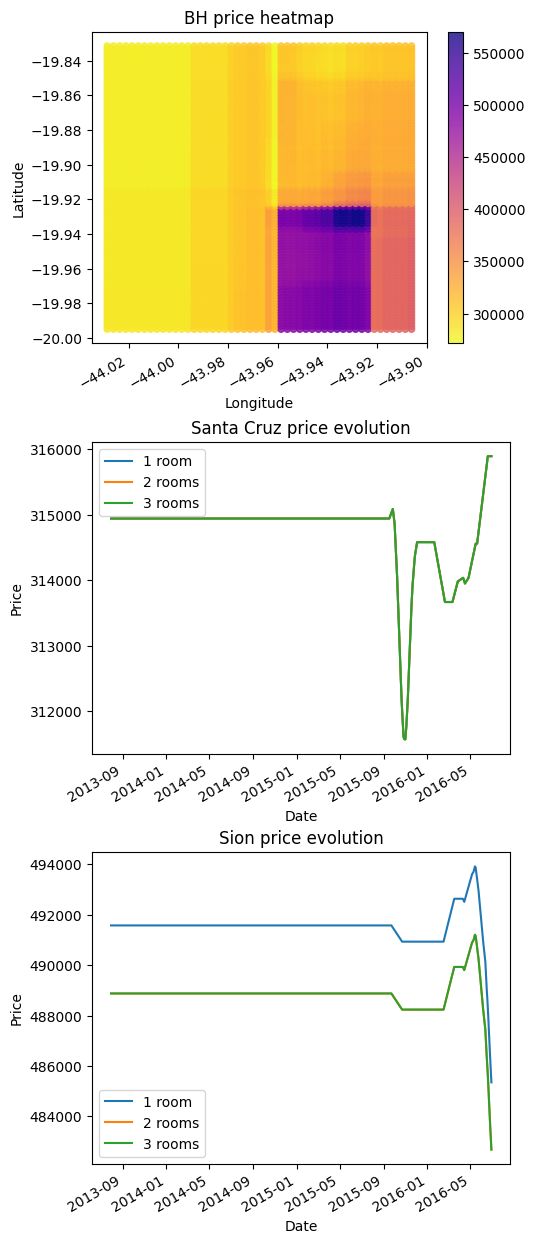

In [135]:
sanity_checks(rf)

Even with the high score, the model behavior is absolutely bad.

**BH price heatmap**: The model struggled to learn information from coordinates and built rectangular patterns. In order to get a more precise rectangular segmentation we need to increase `max_depth` and `n_estimators` to allow the model store more information about the coordinates.

**Price evolution**: In both plots the model cannot see price too much difference between 1, 2 and 3 rooms. In real life every location got more expensive from 2013 to 2016 but for the model the price don't goes up.

I believe it happened because of three reasons:

1) Lack of generalization capabilities in the RF model;
2) Lack of data;
3) RF can learn a limited amount of information given `max_depth` and `n_estimators`. To increase it is necessary to raise `max_depth` and `n_estimators`. Unfortunely, it will increase the model size (which currently is 157.1 MB), increase time to train, increase time to inference, increase RAM usage, and can overfit the model.

Going beyond this point is not worth it. It makes RF not suitable for geospatial data with only coordinates.


## KNN

We are going to give a try to KNN.


In [139]:
from sklearn.neighbors import KNeighborsRegressor

In [149]:
# | notest
knn = KNeighborsRegressor(n_neighbors=15, weights="distance")
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15, weights='distance')

In [48]:
# | hide
# | notest
pickle.dump(knn, open("knn.pickle", "wb"))

In [27]:
# | hide
knn = pickle.load(open("knn.pickle", "rb"))

In [150]:
knn.score(X_valid, y_valid)

0.823111151394615

/tmp/ipykernel_52362/170895895.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


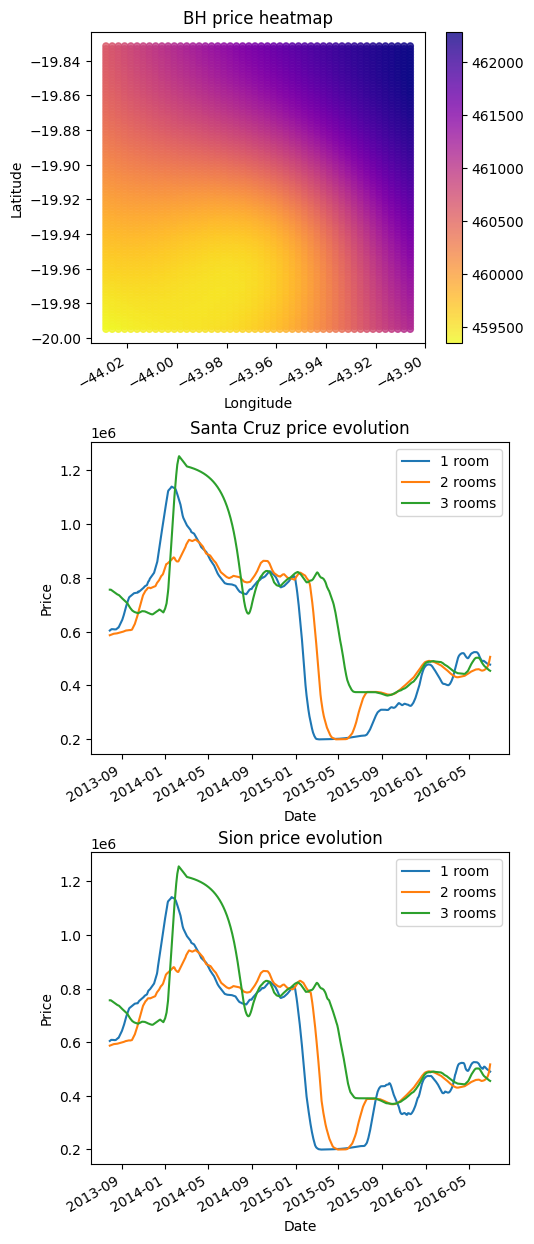

In [151]:
sanity_checks(knn)

Low score and bad model behavior.

**BH price heatmap**: The model struggled to learn information from coordinates (maybe because of other features that are not coordinates) and built a random surface. Even lowering our expectations and allowing for a "low-resolution heatmap" the price should be higher in the bottom of the figure, not lower.

**Price evolution**: In both plots the model cannot see price too much difference between 1, 2 and 3 rooms. The price is the same for a well-known expensive location and a well-known cheap location. In real life every location got more expensive from 2013 to 2016 but for the model the price don't goes up. Instead of it, the price goes up and down "randomly".

This model can "learn" a lot of information but cannot learn the patterns from them.


## Neural Networks

We are going to give a try to neural networks.


In [108]:
from sklearn.neural_network import MLPRegressor

In [155]:
nn = MLPRegressor(
    hidden_layer_sizes=(900, 150, 700),
    verbose=True,
    max_iter=200,
    batch_size=32,
    early_stopping=True,
    random_state=0,
)

nn.fit(X_train, y_train)

Iteration 1, loss = 0.00267249
Validation score: 0.690400


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(batch_size=32, early_stopping=True,
             hidden_layer_sizes=(900, 150, 700, 550, 950, 950), random_state=0,
             verbose=True)

In [153]:
# | hide
# | notest
pickle.dump(nn, open("nn.pickle", "wb"))

In [ ]:
# | hide
nn = pickle.load(open("nn.pickle", "rb"))

In [152]:
nn.score(X_valid, y_valid)

0.8109768135594568

/tmp/ipykernel_52362/170895895.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


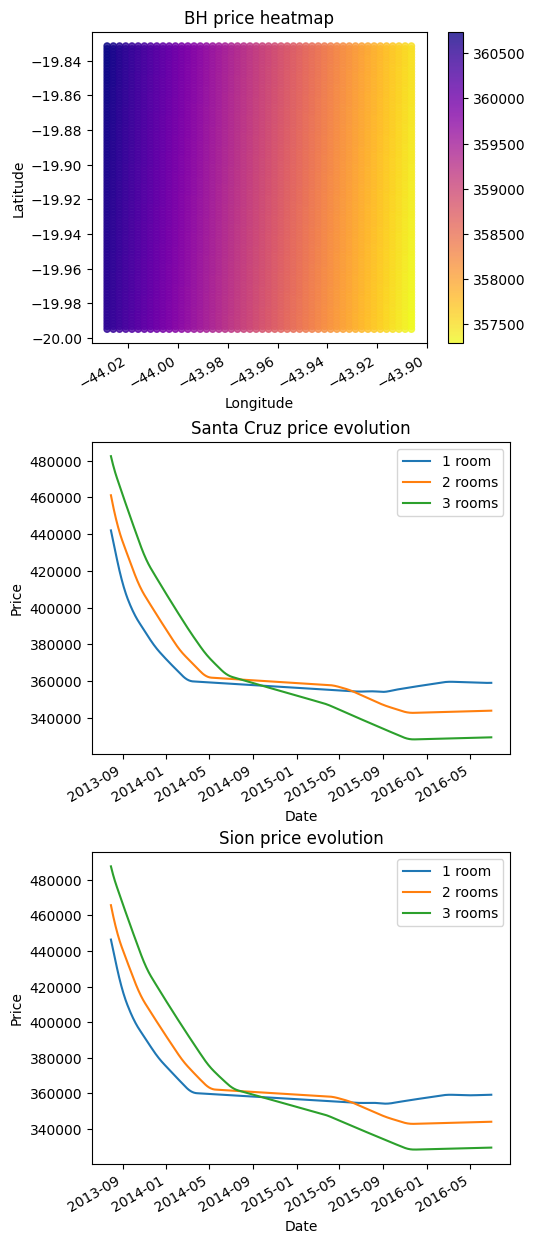

In [154]:
sanity_checks(nn)

Low score and bad model behavior.

**BH price heatmap**: The model struggled to learn information from coordinates and built a "random" surface. Even lowering our expectations and allowing a "low-resolution heatmap" the price should be higher in the bottom of the figure, not lower.

**Price evolution**: In both plots the model cannot see price too much difference between 1, 2 and 3 rooms. The price is the same for a well-known expensive location and a well-known cheap location. In real life every location got more expensive from 2013 to 2016 but for the model the price goes down.

To allow the neural network learn the patterns from the coordinates we will need a lot more parameters and running time.


## Spatial Boosted Random Forest


In [94]:
from knn_spatial_boost.core import KNNSpatialBooster

In [97]:
# | notest
boosted_rf = KNNSpatialBooster(
    n_neighbors=1,
    temperature=0.5,
    n_loops=1,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0),
)

boosted_rf.fit(X_train, y_train)

Running loop #0


In [ ]:
# | hide
# | notest
pickle.dump(boosted_rf, open("boosted_rf.pickle", "wb"))

In [ ]:
# | hide
boosted_rf = pickle.load(open("boosted_rf.pickle", "rb"))

In [98]:
boosted_rf.score(X_valid, y_valid)

0.8508523479725654

/tmp/ipykernel_52362/170895895.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


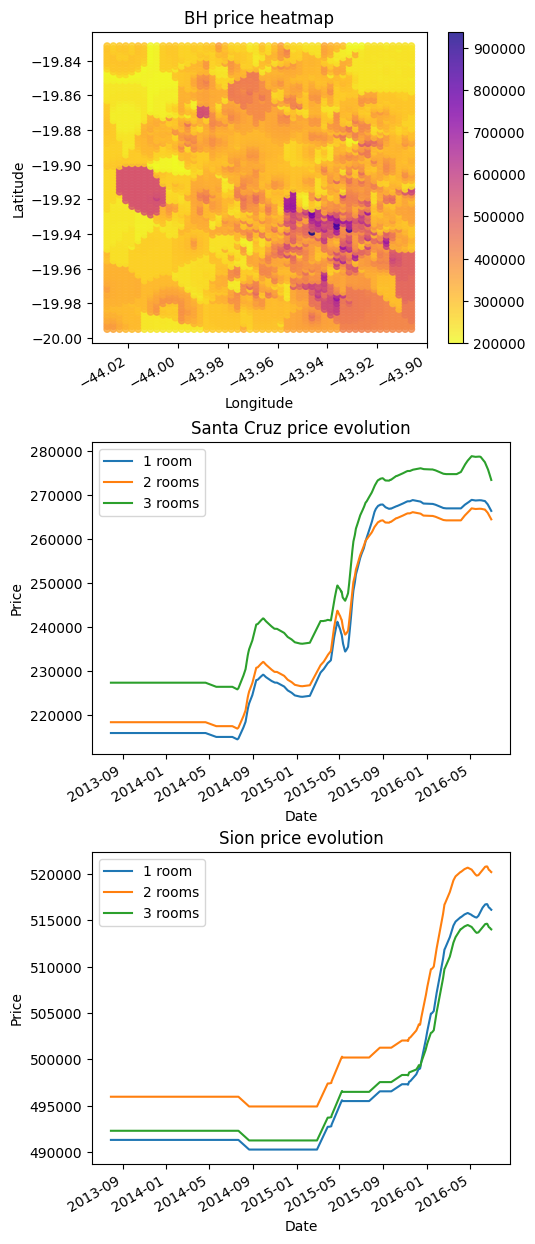

In [100]:
sanity_checks(boosted_rf)

## Spatial Boosted Neural Network

After getting vertical and horizontal patterns using Random Forest and concluding we need a lot more training time to fit a neural network to the data,


In [101]:
from sklearn.neural_network import MLPRegressor

In [115]:
# | notest
boosted_nn = KNNSpatialBooster(
    n_neighbors=1,
    temperature=0.5,
    n_loops=10,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=MLPRegressor(
        hidden_layer_sizes=(64, 32, 16, 8),
        warm_start=True,
        early_stopping=True,
        tol=1e-10,
        n_iter_no_change=20,
        verbose=True,
        max_iter=10,
        batch_size=32,
        random_state=0,
    ),
)

boosted_nn.fit(X_train, y_train)

Running loop #0
Iteration 1, loss = 0.00153531
Validation score: 0.843622
Iteration 2, loss = 0.00088740
Validation score: 0.846057
Iteration 3, loss = 0.00084391
Validation score: 0.834032
Iteration 4, loss = 0.00081650
Validation score: 0.854815
Iteration 5, loss = 0.00080014
Validation score: 0.847629
Iteration 6, loss = 0.00078170
Validation score: 0.856073
Iteration 7, loss = 0.00077483
Validation score: 0.857518
Iteration 8, loss = 0.00076854
Validation score: 0.859685
Iteration 9, loss = 0.00075584
Validation score: 0.817150
Iteration 10, loss = 0.00075805
Validation score: 0.857981
Running loop #1


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00076966
Validation score: 0.843934
Iteration 2, loss = 0.00076009
Validation score: 0.863400
Iteration 3, loss = 0.00075384
Validation score: 0.860689
Iteration 4, loss = 0.00075272
Validation score: 0.864820
Iteration 5, loss = 0.00074952
Validation score: 0.861321
Iteration 6, loss = 0.00074741
Validation score: 0.854041
Iteration 7, loss = 0.00074625
Validation score: 0.865379
Iteration 8, loss = 0.00074104
Validation score: 0.862475
Iteration 9, loss = 0.00074051
Validation score: 0.863804
Iteration 10, loss = 0.00073979
Validation score: 0.866660
Running loop #2


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00073839
Validation score: 0.854867
Iteration 2, loss = 0.00073674
Validation score: 0.862013
Iteration 3, loss = 0.00073635
Validation score: 0.864599
Iteration 4, loss = 0.00073498
Validation score: 0.865810
Iteration 5, loss = 0.00073506
Validation score: 0.862892
Iteration 6, loss = 0.00073407
Validation score: 0.839051
Iteration 7, loss = 0.00073304
Validation score: 0.865538
Iteration 8, loss = 0.00073358
Validation score: 0.859861
Iteration 9, loss = 0.00072926
Validation score: 0.863860
Iteration 10, loss = 0.00073242
Validation score: 0.864513
Running loop #3


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00072899
Validation score: 0.848226
Iteration 2, loss = 0.00072650
Validation score: 0.864516
Iteration 3, loss = 0.00072685
Validation score: 0.866632
Iteration 4, loss = 0.00072635
Validation score: 0.866236
Iteration 5, loss = 0.00072886
Validation score: 0.864880
Iteration 6, loss = 0.00072444
Validation score: 0.852997
Iteration 7, loss = 0.00072655
Validation score: 0.867502
Iteration 8, loss = 0.00072818
Validation score: 0.857106
Iteration 9, loss = 0.00072327
Validation score: 0.861870
Iteration 10, loss = 0.00072539
Validation score: 0.861917
Running loop #4


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00072804
Validation score: 0.859162
Iteration 2, loss = 0.00072708
Validation score: 0.859366
Iteration 3, loss = 0.00072674
Validation score: 0.867209
Iteration 4, loss = 0.00072439
Validation score: 0.870054
Iteration 5, loss = 0.00072640
Validation score: 0.863744
Iteration 6, loss = 0.00072530
Validation score: 0.839734
Iteration 7, loss = 0.00072488
Validation score: 0.869180
Iteration 8, loss = 0.00072713
Validation score: 0.863279
Iteration 9, loss = 0.00072304
Validation score: 0.864585
Iteration 10, loss = 0.00072582
Validation score: 0.864527
Running loop #5


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00072751
Validation score: 0.866769
Iteration 2, loss = 0.00072559
Validation score: 0.868972
Iteration 3, loss = 0.00072672
Validation score: 0.867037
Iteration 4, loss = 0.00072577
Validation score: 0.868705
Iteration 5, loss = 0.00072780
Validation score: 0.865792
Iteration 6, loss = 0.00072387
Validation score: 0.854443
Iteration 7, loss = 0.00072282
Validation score: 0.870906
Iteration 8, loss = 0.00072698
Validation score: 0.864529
Iteration 9, loss = 0.00072248
Validation score: 0.860060
Iteration 10, loss = 0.00072624
Validation score: 0.869403
Running loop #6


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00072151
Validation score: 0.842093
Iteration 2, loss = 0.00072085
Validation score: 0.868100
Iteration 3, loss = 0.00071714
Validation score: 0.868723
Iteration 4, loss = 0.00071990
Validation score: 0.870673
Iteration 5, loss = 0.00072144
Validation score: 0.868227
Iteration 6, loss = 0.00071597
Validation score: 0.853216
Iteration 7, loss = 0.00071907
Validation score: 0.869929
Iteration 8, loss = 0.00072045
Validation score: 0.867263
Iteration 9, loss = 0.00071829
Validation score: 0.863746
Iteration 10, loss = 0.00072072
Validation score: 0.869554
Running loop #7


/home/pedro/repos/knn-spatial-boost/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00071902
Validation score: 0.857446
Iteration 2, loss = 0.00071971
Validation score: 0.865400
Iteration 3, loss = 0.00071852
Validation score: 0.867242
Iteration 4, loss = 0.00072032
Validation score: 0.866157
Iteration 5, loss = 0.00072150
Validation score: 0.865092
Iteration 6, loss = 0.00071797
Validation score: 0.850485
Iteration 7, loss = 0.00071961
Validation score: 0.867542
Iteration 8, loss = 0.00072132
Validation score: 0.865276
Validation score did not improve more than tol=0.000000 for 20 consecutive epochs. Stopping.
Running loop #8
Iteration 1, loss = 0.00071752
Validation score: 0.854541
Validation score did not improve more than tol=0.000000 for 20 consecutive epochs. Stopping.
Running loop #9
Iteration 1, loss = 0.00071912
Validation score: 0.850049
Validation score did not improve more than tol=0.000000 for 20 consecutive epochs. Stopping.


In [ ]:
# | hide
# | notest
pickle.dump(boosted_nn, open("boosted_nn.pickle", "wb"))

In [ ]:
# | hide
boosted_nn = pickle.load(open("boosted_nn.pickle", "rb"))

<Axes: >

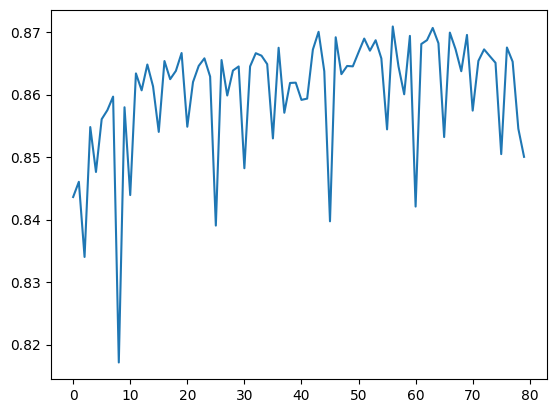

In [116]:
pd.Series(boosted_nn.estimator.validation_scores_).plot()

In [117]:
boosted_nn.score(X_valid, y_valid)

0.836341793408528

/tmp/ipykernel_52362/170895895.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


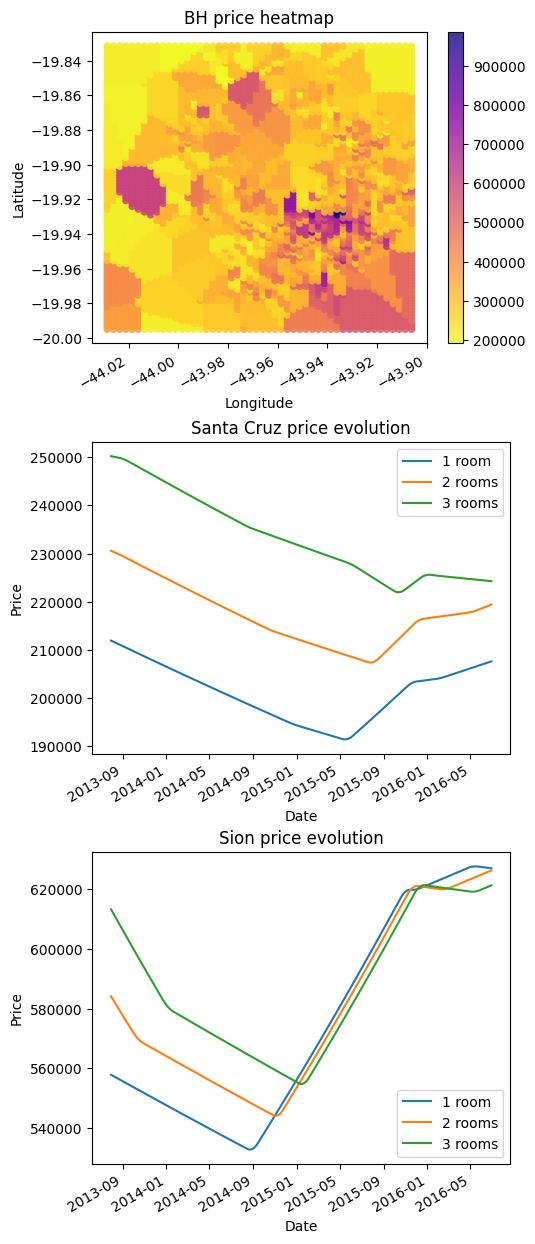

In [118]:
sanity_checks(boosted_nn)

## Conclusion

| Model                          | Time to train | Score | BH check                         | Santa Cruz and Sion check                                                             |
| ------------------------------ | ------------- | ----- | -------------------------------- | ------------------------------------------------------------------------------------- |
| Random Forest                  | 35.1s         | 0.713 | Vertical and horizontal patterns | Colapsing curves                                                                      |
| KNN                            | 0.3s          | 0.448 | Random smooth surface            | Super high variance                                                                   |
| Neural Network                 | 7m42.4s       | 0.446 | Random smooth surface            | Correct curve order but same price for different places and almost constant over time |
| Spatial Boosted Random Forest  | 44.3s         | 0.691 | Seems natural                    | Colapsing curves                                                                      |
| Spatial Boosted Neural Network | 4m57.9s       | 0.582 | Seems natural                    | Correct order and arguable price evolution and price difference between places        |


Random Forest had the best score but with a little bit more investigation we see a bad geospatial generalization and no price difference when adding more rooms. It seems to overfit but due to a lack of data and not to a model inability. We need more spatial features like distance to the nearest city center, hospital, school, public transportation, etc.

KNN had the best time to train but struggles with all other evaluation criteria.

Neural Network seems to underfit. It's expected given the time to train and the complexity of understanding price fluctuation given only coordinates. It's possible to fit a neural network with this data but only with a lot more time to train.

Instead of adding spatial features like distance to the nearest city center, I decided to use KNN to increase model spatial awareness by adding neighbors as features. In addition, I implemented neighbor randomness to improve model generalization.

Spatial Boosted Random Forest had better geospatial generalization but again seems to overfit due to lack of data.

As neural networks have greater generalization capacity, in the end Spatial Boosted Neural Network was the model that best managed to learn the patterns even with little data. It had the best qualitative performance even scoring worse than other models.


## Improvements & Ideas

### About this research

- Generate a GIF to show price evolution throw time.
- Add a online demo for portifolio purposes.

### About the method

- Identify the way this method affect the base model (needs more tuning?).
- Try other dataset to figure out which kind of problem suites better with the technique.
